# Landslide Movements Prediction — MLP & 1D-CNN

This notebook predicts short-term landslide movements using two models:
  1. A Multilayer Perceptron (MLP)
  2. A 1D Convolutional Neural Network (CNN)


**How to use:** place your CSV (same format as the original notebook, e.g., `sample.csv`) in the working directory and update the `DATA_PATH` variable in the 'Load dataset' cell.

# Cell 0 — Install dependencies (run once in a fresh environment)

In [ ]:
# @title Install dependencies
# Cell 0: Install dependencies
# Run once in a fresh environment / Colab
!pip install -q tensorflow scikit-learn matplotlib seaborn joblib shap


# Module 1 — Imports & Configuration

**Purpose:**  
This module centralizes all imports and experiment configuration.  
It sets random seeds, defines the global `CONFIG` dictionary, and prepares the output directory.

All later modules depend on this configuration.

In [ ]:
# @title 1: Imports & CONFIG
# Module 1: Imports & CONFIG
# -------------------------
# Standard libs
import os,random                    # file path handling
import json                   # saving metrics
import datetime               # timestamping run folders
from pathlib import Path      # create output dirs cleanly

# Data / numerical
import numpy as np            # arrays and numeric utilities
import pandas as pd           # tabular data handling

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Persistence
import joblib                 # save/load scaler/encoder objects

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, regularizers

# Scikit-learn utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_auc_score, precision_recall_curve, auc)

# -------------------------
# CONFIG: central place to change experiment parameters
CONFIG = {
    "DATA_PATH": "sample.csv",   # path to raw CSV
    "TARGET_COL": "Movements_t+1",              # name of label column
    "TEST_SIZE": 0.2,                    # holdout fraction
    "RANDOM_STATE": 42,                  # reproducibility seed
    "SCALER_NAME": "scaler.pkl",         # scaler filename to save
    "OUTPUT_DIR": "outputs",             # where to save models & metrics
    "EPOCHS": 100,                       # training epochs
    "BATCH_SIZE": 64,                    # batch size
    "EARLYSTOP_PATIENCE": 8,             # early stopping patience
    "DEFAULT_THRESHOLDS": None,          # per-class thresholds dict or None
    "SAVE_MODELS": True,                 # toggle saving models
    "ENCODER_PATH": None,                # optional path for label encoder
    "FEATURE_ORDER": None                # optional fixed feature order
}

# create outputs dir if missing
Path(CONFIG["OUTPUT_DIR"]).mkdir(parents=True, exist_ok=True)

# set seeds for reproducibility (note: full determinism may still vary by TF build/hardware)
np.random.seed(CONFIG["RANDOM_STATE"])
tf.random.set_seed(CONFIG["RANDOM_STATE"])



# Module 2.1 — DataEngine

**Purpose:**  
  

*   Defines the `DataEngine` class responsible for dataset handling.
*   It loads the CSV file, drops unwanted columns (date/time), handles NA values, applies optional feature ordering, and prepares feature matrix `X` and encoded labels `y`.




**Key responsibilities:**
- Load and clean the dataset  
- Enforce deterministic feature ordering  
- Encode target labels into integers  
- Provide reversible label mapping  

In [ ]:
# @title 2.1: DataEngine
# Module 2.1: DataEngine class - loads and prepares data
# -----------------------------------------------------
from sklearn.preprocessing import LabelEncoder

class DataEngine:
    def __init__(self, config):
        # store config and convenient names
        self.config = config
        self.data_path = config.get("DATA_PATH")
        self.target_col = config.get("TARGET_COL", "target")
        self.feature_order = config.get("FEATURE_ORDER", None)
        self.encoder_path = config.get("ENCODER_PATH", None)
        self.df = None
        self.label_encoder = None

    def _drop_date_column(self, df):
        # drop obvious date/time columns to avoid leaking temporal index
        date_candidates = [c for c in df.columns if c.lower() == "date" or "time" in c.lower()]
        if date_candidates:
            df = df.drop(columns=date_candidates, errors="ignore")
        return df

    def load_data(self, dropna=True, verbose=True):
        # load CSV and perform light cleaning
        if not self.data_path or not os.path.exists(self.data_path):
            raise FileNotFoundError(f"DataEngine: file not found at {self.data_path}")
        df = pd.read_csv(self.data_path)
        df = self._drop_date_column(df)   # drop date/time if present
        if dropna:
            df = df.dropna().reset_index(drop=True)  # drop incomplete rows
        if self.target_col not in df.columns:
            raise ValueError(f"Target column '{self.target_col}' missing in data")
        # reorder if feature_order provided (target kept at end)
        if self.feature_order:
            missing = [c for c in self.feature_order if c not in df.columns]
            if missing:
                raise ValueError(f"FEATURE_ORDER contains unknown columns: {missing}")
            ordered = [c for c in self.feature_order if c != self.target_col] + [self.target_col]
            df = df[ordered]
        self.df = df.copy()
        if verbose:
            print(f"DataEngine: loaded {len(self.df)} rows, {len(self.df.columns)} columns")
        return self.df

    def get_feature_names(self):
        # return list of feature columns (exclude target)
        if self.df is None:
            raise RuntimeError("No data loaded; call load_data() first")
        return [c for c in self.df.columns if c != self.target_col]

    def prepare_X_y(self, df=None, return_dataframe=False):
        # prepare X (numpy 2D) and y (numpy 1D integer labels)
        if df is None:
            if self.df is None:
                raise RuntimeError("No df available; load or pass df explicitly")
            df = self.df
        if self.feature_order:
            feature_cols = [c for c in self.feature_order if c != self.target_col]
        else:
            feature_cols = [c for c in df.columns if c != self.target_col]
        X_df = df[feature_cols].copy()
        y_series = df[self.target_col].copy()
        # encode labels to integers if required
        if y_series.dtype.kind in 'O' or not np.issubdtype(y_series.dtype, np.integer):
            le = LabelEncoder()
            y_enc = le.fit_transform(y_series)
            self.label_encoder = le
            if self.encoder_path:
                joblib.dump(le, self.encoder_path)
        else:
            y_enc = y_series.astype(int).values
            le = LabelEncoder(); le.fit(y_enc); self.label_encoder = le
            if self.encoder_path:
                joblib.dump(le, self.encoder_path)
        if return_dataframe:
            return X_df, pd.Series(y_enc, name=self.target_col)
        return X_df.values, y_enc

    def inverse_transform_labels(self, y_int_array):
        # revert integer labels to original labels (if encoder present)
        if self.label_encoder is None:
            raise RuntimeError("LabelEncoder not fitted")
        return self.label_encoder.inverse_transform(y_int_array)


# Module 2.2 — DataAnalyzer

**Purpose:**  
Provides lightweight exploratory data analysis utilities. Helps visualize class distribution, inspect missing values, and generate correlation heatmaps for top features.


In [ ]:
# @title 2.2: DataAnalyzer
# Module 2.2: DataAnalyzer - EDA helper functions
# -----------------------------------------------
class DataAnalyzer:
    def __init__(self):
        pass

    def summary(self, df, top_n_features=30):
        # print shape and missing values, show numeric description
        print("Data shape:", df.shape)
        print("Missing values per column:")
        display(df.isnull().sum().sort_values(ascending=False).head(50))
        print("Numeric description (top features):")
        display(df.select_dtypes(include=[np.number]).describe().transpose().head(top_n_features))

    def plot_class_distribution(self, df, target_col):
        # bar plot of class counts for target
        if target_col not in df.columns:
            raise ValueError(f"Target '{target_col}' not in dataframe")
        counts = df[target_col].value_counts().sort_index()
        plt.figure(figsize=(6,4))
        sns.barplot(x=counts.index, y=counts.values)
        plt.title(f"Class distribution ({target_col})")
        plt.ylabel("Count"); plt.xlabel("Class")
        plt.show()

    def _temporary_encode_target(self, df, target_col):
        # encode target to numeric for correlation computation (no mutation of original df)
        y = df[target_col]
        if y.dtype.kind in 'O' or not np.issubdtype(y.dtype, np.number):
            le = LabelEncoder()
            y_enc = le.fit_transform(y)
            return df.copy(), y_enc, le
        if not np.issubdtype(y.dtype, np.integer):
            uniques, y_enc = np.unique(y, return_inverse=True)
            return df.copy(), y_enc, None
        return df.copy(), y.values, None

    def plot_correlation_matrix(self, df, target_col, top_n=15, annotate=False, figsize=(10,8)):
        # compute Pearson correlation between numeric features and encoded target
        if target_col not in df.columns:
            raise ValueError(f"Target '{target_col}' missing")
        df_copy, y_enc, _ = self._temporary_encode_target(df, target_col)
        numeric = df_copy.select_dtypes(include=[np.number]).copy()
        if target_col in numeric.columns:
            numeric_target = numeric[target_col].values
        else:
            numeric[target_col] = y_enc
            numeric_target = numeric[target_col].values
        corrs = {}
        for col in numeric.columns:
            if col == target_col: continue
            try:
                corr = np.corrcoef(numeric[col].astype(float), numeric_target.astype(float))[0,1]
            except Exception:
                corr = 0.0
            corrs[col] = 0.0 if np.isnan(corr) else corr
        top_features = sorted(corrs.keys(), key=lambda k: abs(corrs[k]), reverse=True)[:top_n]
        sel = top_features + [target_col]
        corr_mat = numeric[sel].corr()
        plt.figure(figsize=figsize)
        sns.heatmap(corr_mat, annot=annotate, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.25)
        plt.title(f"Correlation matrix (top {len(top_features)} features vs {target_col})")
        plt.show()

    def top_correlated_features(self, df, target_col, top_n=20):
        # return DataFrame of top features sorted by absolute correlation with target
        df_copy, y_enc, _ = self._temporary_encode_target(df, target_col)
        numeric = df_copy.select_dtypes(include=[np.number]).copy()
        if target_col not in numeric.columns:
            numeric[target_col] = y_enc
        corrs = {}
        for col in numeric.columns:
            if col == target_col: continue
            try:
                corr = np.corrcoef(numeric[col].astype(float), numeric[target_col].astype(float))[0,1]
            except Exception:
                corr = 0.0
            corrs[col] = 0.0 if np.isnan(corr) else corr
        out = pd.DataFrame([{"feature": k, "corr": v, "abs_corr": abs(v)} for k, v in corrs.items()]) \
                .sort_values("abs_corr", ascending=False).reset_index(drop=True)
        return out.head(top_n)


# Module 2.3 — Data Loading, EDA, Scaling, Holdout Split

**Purpose:**  
Uses `DataEngine` and `DataAnalyzer` to prepare the dataset for modeling.

**Steps in this module:**
1. Load dataset  
2. Print shape and class balance  
3. Visualize correlations using `DataAnalyzer`  
4. Prepare `X` and `y`  
5. Perform stratified train–holdout split  
6. Fit `StandardScaler` on training data only  
7. Transform holdout data  
8. Save the fitted scaler  

This module ensures no data leakage and preserves class distribution.


DataEngine: loaded 20044 rows, 53 columns
Data shape: (20044, 53)
Target distribution:
 Movements_t+1
0    19220
1      613
2      211
Name: count, dtype: int64


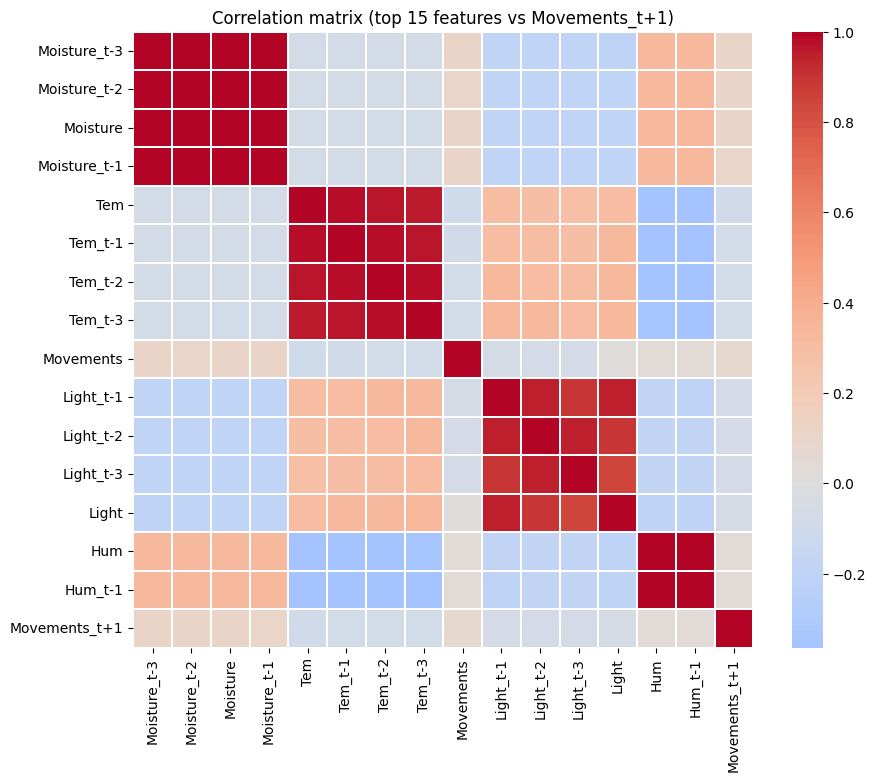

Scaler saved to: outputs/scaler.pkl
Prepared data. Train shape: (16035, 52) Holdout shape: (4009, 52)


In [ ]:
# @title 2.3
# Module 2.3: Load data, EDA, scale, holdout split
# ------------------------------------------------
# instantiate engine with CONFIG (expects DATA_PATH etc.)
engine = DataEngine(CONFIG)

# load cleaned dataframe (drops NA and Date/time by default)
df = engine.load_data()

# quick checks for user visibility
print("Data shape:", df.shape)
print("Target distribution:\n", df[CONFIG["TARGET_COL"]].value_counts())

# run EDA
analyzer = DataAnalyzer()
analyzer.plot_correlation_matrix(df, CONFIG["TARGET_COL"], top_n=15, annotate=False)

# build X (numpy 2D) and y (integer labels)
X, y = engine.prepare_X_y(df)

# create stratified holdout to preserve class balance
X_train_full, X_holdout, y_train_full, y_holdout = train_test_split(
    X, y,
    test_size=CONFIG["TEST_SIZE"],
    stratify=y,
    random_state=CONFIG["RANDOM_STATE"]
)

# scale features using StandardScaler: fit on training only to avoid leakage
scaler = StandardScaler()
X_train_full = scaler.fit_transform(X_train_full)   # fit on train
X_holdout = scaler.transform(X_holdout)             # transform holdout with same scaler

# persist scaler for inference later
scaler_path = os.path.join(CONFIG["OUTPUT_DIR"], CONFIG["SCALER_NAME"])
joblib.dump(scaler, scaler_path)
print("Scaler saved to:", scaler_path)

# final sanity shapes
print("Prepared data. Train shape:", X_train_full.shape, "Holdout shape:", X_holdout.shape)



# Module 3 — Model Builders (MLP and 1D-CNN)

**Purpose:**  
Defines the two neural network architectures used in this notebook:
- A Multilayer Perceptron (MLP)  
- A 1D Convolutional Neural Network (1D-CNN)

**Why separate?**  
To keep network architecture definitions isolated from training logic.

MLP uses flat inputs, while the CNN reshapes data to `(samples, 1, features)`.


In [ ]:
# @title 3.1 MLP model
# Module 3: Model builders
# -----------------------
from tensorflow.keras import regularizers

def build_mlp(input_dim, n_classes, dropout=0.3, l2=1e-4):
    # Simple MLP for tabular/lag features
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),                     # input layer placeholder
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        layers.BatchNormalization(),
        layers.Dropout(dropout),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        layers.BatchNormalization(),
        layers.Dropout(dropout),
        layers.Dense(64, activation='relu'),
        layers.Dense(n_classes, activation='softmax')        # multi-class softmax output
    ])
    model.compile(optimizer=optimizers.Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
# @title 3.2 CNN1D model

def build_cnn_1d(input_len, n_feats, n_classes, dropout=0.3, l2=1e-4):
    # 1D-CNN for sequence-like or grouped lag features
    inp = layers.Input(shape=(input_len, n_feats))          # shape: (timesteps, features_per_step)
    x = layers.Conv1D(64, kernel_size=3, padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(l2))(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(128, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.GlobalAveragePooling1D()(x)                 # reduce temporal dimension
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(n_classes, activation='softmax')(x)
    model = models.Model(inputs=inp, outputs=out)
    model.compile(optimizer=optimizers.Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Module 4 — Evaluator (Thresholding & Metrics)

**Purpose:**  
Provides evaluation utilities shared by all models.

**Includes:**
- Probability thresholding (`apply_thresholds`)  
- Classification metrics (`compute_metrics`)  
  - Accuracy  
  - Precision (macro)  
  - Recall (macro)  
  - F1-score (macro)  
  - Confusion matrix  
  - PR-AUC and ROC-AUC per class  




In [ ]:
# @title 4: Evaluator
# Module 4: Evaluator utilities
# -----------------------------

def apply_thresholds(prob_array, thresholds=None):
    """
    Convert probability matrix (n_samples, n_classes) -> predicted class indices.
    If thresholds is None => argmax (default).
    If thresholds provided (dict), require probability >= threshold to select class.
    Fallback: argmax if none pass.
    """
    if thresholds is None:
        return np.argmax(prob_array, axis=1)
    preds = []
    for p in prob_array:
        passed = [i for i, pr in enumerate(p) if pr >= thresholds.get(i, 0.5)]
        if len(passed) == 1:
            preds.append(passed[0])
        elif len(passed) > 1:
            preds.append(int(np.argmax(p)))  # choose max prob among passed
        else:
            preds.append(int(np.argmax(p)))  # fallback to argmax
    return np.array(preds)

def compute_metrics(y_true, y_pred, probas=None):
    # compute a standard set of metrics and return in a dict for saving
    metrics = {}
    metrics['accuracy'] = float(accuracy_score(y_true, y_pred))
    metrics['precision_macro'] = float(precision_score(y_true, y_pred, average='macro', zero_division=0))
    metrics['recall_macro'] = float(recall_score(y_true, y_pred, average='macro', zero_division=0))
    metrics['f1_macro'] = float(f1_score(y_true, y_pred, average='macro', zero_division=0))
    metrics['confusion_matrix'] = confusion_matrix(y_true, y_pred).tolist()
    # compute PR-AUC and ROC-AUC per class if probabilities are available
    if probas is not None and probas.shape[1] > 1:
        pr_aucs, roc_aucs = [], []
        for i in range(probas.shape[1]):
            y_bin = (y_true == i).astype(int)
            try:
                precision, recall, _ = precision_recall_curve(y_bin, probas[:, i])
                pr_aucs.append(float(auc(recall, precision)))
            except Exception:
                pr_aucs.append(float('nan'))
            try:
                roc_aucs.append(float(roc_auc_score(y_bin, probas[:, i])))
            except Exception:
                roc_aucs.append(float('nan'))
        metrics['pr_auc_per_class'] = pr_aucs
        metrics['roc_auc_per_class'] = roc_aucs
        metrics['pr_auc_macro'] = float(np.nanmean(pr_aucs))
        metrics['roc_auc_macro'] = float(np.nanmean(roc_aucs))
    return metrics


# Module 5 — Plotting & Saving Utilities

**Purpose:**  
Handles visualization of training curves and saving of model files and metrics.

**Includes:**
- Loss and accuracy curves  
- Metrics saved as JSON  
- Model saved as `.h5`  




In [ ]:
# @title Module 5.1: Plot & save utilities

# plotting and saving helpers
# ------------------------------------

def _plot_history(history, title=None, save_path=None):
    # visualize loss and accuracy curves; accepts Keras History object
    if history is None:
        return
    hist = history.history
    epochs = range(1, len(hist['loss']) + 1)
    plt.figure(figsize=(12,4))
    # Loss subplot
    plt.subplot(1,2,1)
    plt.plot(epochs, hist['loss'], label='train_loss')
    if 'val_loss' in hist:
        plt.plot(epochs, hist['val_loss'], label='val_loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss')
    # Accuracy subplot (support both 'accuracy' and 'acc' keys)
    plt.subplot(1,2,2)
    acc_key = 'accuracy' if 'accuracy' in hist else ('acc' if 'acc' in hist else None)
    val_acc_key = 'val_accuracy' if 'val_accuracy' in hist else ('val_acc' if 'val_acc' in hist else None)
    if acc_key:
        plt.plot(epochs, hist[acc_key], label='train_acc')
    if val_acc_key:
        plt.plot(epochs, hist[val_acc_key], label='val_acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Accuracy')
    if title:
        plt.suptitle(title)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.show()

def _save_metrics_and_model_files(model, metrics_dict, model_name, output_dir=CONFIG["OUTPUT_DIR"]):
    # save metrics JSON and model H5 inside timestamped folder for reproducibility
    ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    outdir = Path(output_dir) / f"{model_name}_{ts}"
    outdir.mkdir(parents=True, exist_ok=True)
    metrics_path = outdir / "metrics.json"
    with open(metrics_path, "w") as f:
        json.dump(metrics_dict, f, indent=2)
    print("Saved metrics to", metrics_path)
    if CONFIG["SAVE_MODELS"] and model is not None:
        model_file = outdir / f"{model_name}.h5"
        model.save(str(model_file))
        print("Saved model to", model_file)
    return str(outdir)

# save wrapper
def save_run_outputs(model, metrics, model_name, history=None):
    # calls saver to persist metrics and model
    base_outdir = _save_metrics_and_model_files(model, metrics, model_name, CONFIG["OUTPUT_DIR"])
    if history is not None:
        plot_path = Path(base_outdir) / "training_curves.png"
        _plot_history(history, title=model_name, save_path=str(plot_path))
    return base_outdir


# Module 6 — Training Pipeline (`run_single_model`)

**Purpose:**  
Implements a reusable model training pipeline.

**What this module does:**
1. Builds model using a builder function  
2. Applies class weights for imbalance  
3. Uses EarlyStopping and ModelCheckpoint  
4. Trains with validation split  
5. Predicts on holdout data  
6. Applies probability thresholds  
7. Computes metrics  
8. Saves the run results  

Both MLP and CNN use this exact pipeline.


In [ ]:
# @title 6: Run a single model
# Module 6: training + evaluation pipeline
def run_single_model(model_builder_fn,
                     model_name,
                     X_train,
                     y_train,
                     X_holdout,
                     y_holdout,
                     thresholds=None,
                     use_class_weight=True,
                     builder_kwargs=None):
    """
    Generic training pipeline:
    - model_builder_fn: function that returns a compiled Keras model
    - builder_kwargs: input dimensions etc. (passed to builder)
    - X_train: 2D/3D array depending on model
    - X_holdout: 2D/3D array for predict
    """
    builder_kwargs = builder_kwargs or {}

    # compute class weights (balanced) if desired
    classes = np.unique(y_train)
    if use_class_weight:
        cw = compute_class_weight('balanced', classes=classes, y=y_train)
        class_weight_dict = {c: w for c, w in zip(classes, cw)}
    else:
        class_weight_dict = None

    # instantiate model using provided builder
    model = model_builder_fn(**builder_kwargs)

    # prepare callbacks: early stopping and model checkpoint
    es = callbacks.EarlyStopping(monitor='val_loss', patience=CONFIG["EARLYSTOP_PATIENCE"], restore_best_weights=True)
    chk_path = os.path.join(CONFIG["OUTPUT_DIR"], f"{model_name}_best.h5")
    mc = callbacks.ModelCheckpoint(chk_path, save_best_only=True, monitor='val_loss')

    # fit model; validation_split used for quick val monitoring
    history = model.fit(
        X_train,
        y_train,
        validation_split=0.2,
        epochs=CONFIG["EPOCHS"],
        batch_size=CONFIG["BATCH_SIZE"],
        class_weight=class_weight_dict,
        callbacks=[es, mc],
        verbose=2
    )

    # predict probabilities on holdout and apply thresholds
    probas = model.predict(X_holdout)
    preds = apply_thresholds(probas, thresholds if thresholds is not None else CONFIG["DEFAULT_THRESHOLDS"])

    # compute metrics
    metrics = compute_metrics(y_holdout, preds, probas=probas)

    # save model and metrics, return a dict for downstream analysis
    outdir = save_run_outputs(model, metrics, model_name, history=history)
    return {"model": model, "history": history, "metrics": metrics, "outdir": outdir, "preds": preds, "probas": probas}



# Module 6.1 — Run MLP

**Purpose:**  
Runs the MLP architecture through the standardized training pipeline.

**Notes:**
- Uses flattened feature matrix  
- Outputs stored under `mlp_result`  

Epoch 1/100


201/201 - 4s - 20ms/step - accuracy: 0.5384 - loss: 1.1268 - val_accuracy: 0.4587 - val_loss: 1.1157
Epoch 2/100


201/201 - 1s - 5ms/step - accuracy: 0.5309 - loss: 0.9912 - val_accuracy: 0.5585 - val_loss: 0.9795
Epoch 3/100


201/201 - 1s - 5ms/step - accuracy: 0.5339 - loss: 0.9782 - val_accuracy: 0.5575 - val_loss: 0.9193
Epoch 4/100


201/201 - 1s - 6ms/step - accuracy: 0.5530 - loss: 0.8483 - val_accuracy: 0.5990 - val_loss: 0.8107
Epoch 5/100
201/201 - 1s - 5ms/step - accuracy: 0.5477 - loss: 0.8392 - val_accuracy: 0.5790 - val_loss: 0.8225
Epoch 6/100
201/201 - 1s - 4ms/step - accuracy: 0.5694 - loss: 0.8092 - val_accuracy: 0.5550 - val_loss: 0.8250
Epoch 7/100


201/201 - 1s - 5ms/step - accuracy: 0.5629 - loss: 0.7989 - val_accuracy: 0.5815 - val_loss: 0.7715
Epoch 8/100
201/201 - 1s - 5ms/step - accuracy: 0.5652 - loss: 0.7949 - val_accuracy: 0.5653 - val_loss: 0.8424
Epoch 9/100
201/201 - 1s - 7ms/step - accuracy: 0.5610 - loss: 0.7463 - val_accuracy: 0.5766 - val_loss: 0.8367
Epoch 10/100
201/201 - 1s - 6ms/step - accuracy: 0.5597 - loss: 0.7698 - val_accuracy: 0.5731 - val_loss: 0.7779
Epoch 11/100


201/201 - 1s - 5ms/step - accuracy: 0.5680 - loss: 0.7127 - val_accuracy: 0.5847 - val_loss: 0.7383
Epoch 12/100
201/201 - 1s - 6ms/step - accuracy: 0.5656 - loss: 0.7374 - val_accuracy: 0.5750 - val_loss: 0.7490
Epoch 13/100
201/201 - 1s - 4ms/step - accuracy: 0.5679 - loss: 0.7163 - val_accuracy: 0.5847 - val_loss: 0.7677
Epoch 14/100


201/201 - 1s - 5ms/step - accuracy: 0.5726 - loss: 0.7140 - val_accuracy: 0.6006 - val_loss: 0.7248
Epoch 15/100


201/201 - 1s - 5ms/step - accuracy: 0.5663 - loss: 0.6984 - val_accuracy: 0.6099 - val_loss: 0.7109
Epoch 16/100
201/201 - 1s - 5ms/step - accuracy: 0.5838 - loss: 0.6806 - val_accuracy: 0.5956 - val_loss: 0.7150
Epoch 17/100
201/201 - 1s - 5ms/step - accuracy: 0.5789 - loss: 0.6716 - val_accuracy: 0.6027 - val_loss: 0.7260
Epoch 18/100


201/201 - 1s - 5ms/step - accuracy: 0.5919 - loss: 0.6339 - val_accuracy: 0.6208 - val_loss: 0.6442
Epoch 19/100
201/201 - 1s - 5ms/step - accuracy: 0.5867 - loss: 0.6684 - val_accuracy: 0.6321 - val_loss: 0.6696
Epoch 20/100
201/201 - 1s - 6ms/step - accuracy: 0.5905 - loss: 0.6746 - val_accuracy: 0.6090 - val_loss: 0.6624
Epoch 21/100
201/201 - 1s - 7ms/step - accuracy: 0.5988 - loss: 0.6472 - val_accuracy: 0.6302 - val_loss: 0.7079
Epoch 22/100
201/201 - 1s - 5ms/step - accuracy: 0.5718 - loss: 0.6339 - val_accuracy: 0.6180 - val_loss: 0.6661
Epoch 23/100


201/201 - 1s - 5ms/step - accuracy: 0.5903 - loss: 0.6269 - val_accuracy: 0.6629 - val_loss: 0.6068
Epoch 24/100
201/201 - 1s - 4ms/step - accuracy: 0.6034 - loss: 0.6120 - val_accuracy: 0.6215 - val_loss: 0.6574
Epoch 25/100
201/201 - 1s - 5ms/step - accuracy: 0.5948 - loss: 0.6537 - val_accuracy: 0.6470 - val_loss: 0.6094
Epoch 26/100
201/201 - 1s - 4ms/step - accuracy: 0.5977 - loss: 0.6057 - val_accuracy: 0.6324 - val_loss: 0.6407
Epoch 27/100
201/201 - 1s - 4ms/step - accuracy: 0.6030 - loss: 0.6077 - val_accuracy: 0.6205 - val_loss: 0.6522
Epoch 28/100
201/201 - 1s - 4ms/step - accuracy: 0.5598 - loss: 0.6347 - val_accuracy: 0.6623 - val_loss: 0.6163
Epoch 29/100
201/201 - 1s - 4ms/step - accuracy: 0.5995 - loss: 0.6134 - val_accuracy: 0.6374 - val_loss: 0.6432
Epoch 30/100


201/201 - 1s - 5ms/step - accuracy: 0.6067 - loss: 0.5742 - val_accuracy: 0.6498 - val_loss: 0.5724
Epoch 31/100
201/201 - 1s - 4ms/step - accuracy: 0.6144 - loss: 0.5726 - val_accuracy: 0.6501 - val_loss: 0.6298
Epoch 32/100
201/201 - 1s - 4ms/step - accuracy: 0.5957 - loss: 0.5713 - val_accuracy: 0.6854 - val_loss: 0.5772
Epoch 33/100
201/201 - 1s - 6ms/step - accuracy: 0.6051 - loss: 0.5998 - val_accuracy: 0.6377 - val_loss: 0.6085
Epoch 34/100
201/201 - 2s - 8ms/step - accuracy: 0.6091 - loss: 0.5959 - val_accuracy: 0.6445 - val_loss: 0.5983
Epoch 35/100


201/201 - 2s - 9ms/step - accuracy: 0.6272 - loss: 0.5236 - val_accuracy: 0.6757 - val_loss: 0.5722
Epoch 36/100


201/201 - 1s - 5ms/step - accuracy: 0.6246 - loss: 0.5306 - val_accuracy: 0.6582 - val_loss: 0.5705
Epoch 37/100


201/201 - 1s - 5ms/step - accuracy: 0.6211 - loss: 0.5604 - val_accuracy: 0.7309 - val_loss: 0.5326
Epoch 38/100
201/201 - 1s - 4ms/step - accuracy: 0.6256 - loss: 0.5452 - val_accuracy: 0.7184 - val_loss: 0.5637
Epoch 39/100
201/201 - 1s - 4ms/step - accuracy: 0.6372 - loss: 0.5686 - val_accuracy: 0.7075 - val_loss: 0.6469
Epoch 40/100
201/201 - 1s - 4ms/step - accuracy: 0.6087 - loss: 0.5763 - val_accuracy: 0.7817 - val_loss: 0.5493
Epoch 41/100
201/201 - 1s - 6ms/step - accuracy: 0.6162 - loss: 0.5774 - val_accuracy: 0.7325 - val_loss: 0.5598
Epoch 42/100
201/201 - 1s - 6ms/step - accuracy: 0.6246 - loss: 0.5465 - val_accuracy: 0.6604 - val_loss: 0.6028
Epoch 43/100


201/201 - 1s - 5ms/step - accuracy: 0.6430 - loss: 0.5307 - val_accuracy: 0.8329 - val_loss: 0.4969
Epoch 44/100
201/201 - 1s - 7ms/step - accuracy: 0.6411 - loss: 0.5246 - val_accuracy: 0.7521 - val_loss: 0.5721
Epoch 45/100
201/201 - 1s - 7ms/step - accuracy: 0.6309 - loss: 0.5262 - val_accuracy: 0.7608 - val_loss: 0.5677
Epoch 46/100
201/201 - 1s - 5ms/step - accuracy: 0.6382 - loss: 0.5253 - val_accuracy: 0.7633 - val_loss: 0.5660
Epoch 47/100
201/201 - 1s - 5ms/step - accuracy: 0.6354 - loss: 0.5321 - val_accuracy: 0.7930 - val_loss: 0.5670
Epoch 48/100
201/201 - 1s - 5ms/step - accuracy: 0.6377 - loss: 0.5496 - val_accuracy: 0.6991 - val_loss: 0.5688
Epoch 49/100
201/201 - 1s - 5ms/step - accuracy: 0.6395 - loss: 0.5318 - val_accuracy: 0.7649 - val_loss: 0.4983
Epoch 50/100
201/201 - 1s - 4ms/step - accuracy: 0.6411 - loss: 0.5281 - val_accuracy: 0.6882 - val_loss: 0.5559
Epoch 51/100
201/201 - 1s - 5ms/step - accuracy: 0.6331 - loss: 0.5201 - val_accuracy: 0.8051 - val_loss: 0.5

Saved metrics to outputs/mlp_v1_20251204_102202/metrics.json
Saved model to outputs/mlp_v1_20251204_102202/mlp_v1.h5


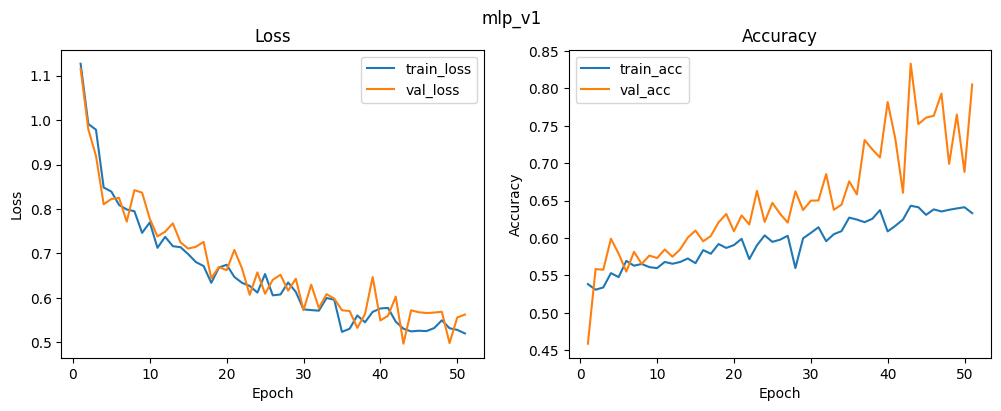

MLP metrics: {'accuracy': 0.83711648790222, 'precision_macro': 0.3802860839964905, 'recall_macro': 0.5345613055506205, 'f1_macro': 0.391129884485629, 'confusion_matrix': [[3305, 261, 278], [75, 30, 18], [17, 4, 21]], 'pr_auc_per_class': [0.984019003837206, 0.08085143337386567, 0.06392080318644491], 'roc_auc_per_class': [0.7497682338473182, 0.7093234416646792, 0.8502016637257372], 'pr_auc_macro': 0.3762637467991721, 'roc_auc_macro': 0.7697644464125782}


In [ ]:
# @title 6.1: Run MLP
# Module 7.1: Run MLP
# prepare inputs
X_train = X_train_full                    # 2D numpy array of shape (N, num_features)
X_hold = X_holdout
y_tr = y_train_full
y_hd = y_holdout
n_classes = len(np.unique(y_tr))
input_dim = X_train.shape[1]

# call pipeline
mlp_result = run_single_model(
    model_builder_fn=lambda input_dim, n_classes: build_mlp(input_dim=input_dim, n_classes=n_classes),
    model_name="mlp_v1",
    X_train=X_train,
    y_train=y_tr,
    X_holdout=X_hold,
    y_holdout=y_hd,
    thresholds=CONFIG["DEFAULT_THRESHOLDS"],
    use_class_weight=True,
    builder_kwargs={"input_dim": input_dim, "n_classes": n_classes}
)

# quick check
print("MLP metrics:", mlp_result["metrics"])


# Module 6.2 — Run 1D-CNN

**Purpose:**  
Runs the CNN architecture through the same pipeline.

**Notes:**
- Reshapes data to `(samples, 1, features)`  
- Outputs stored under `cnn_result`  

Epoch 1/100


201/201 - 3s - 15ms/step - accuracy: 0.5470 - loss: 0.9941 - val_accuracy: 0.5669 - val_loss: 0.8625
Epoch 2/100


201/201 - 1s - 4ms/step - accuracy: 0.5451 - loss: 0.8516 - val_accuracy: 0.5703 - val_loss: 0.8053
Epoch 3/100
201/201 - 1s - 4ms/step - accuracy: 0.5541 - loss: 0.8048 - val_accuracy: 0.5619 - val_loss: 0.8227
Epoch 4/100


201/201 - 1s - 4ms/step - accuracy: 0.5716 - loss: 0.7530 - val_accuracy: 0.5753 - val_loss: 0.7704
Epoch 5/100


201/201 - 1s - 4ms/step - accuracy: 0.5840 - loss: 0.7195 - val_accuracy: 0.5974 - val_loss: 0.7499
Epoch 6/100


201/201 - 1s - 4ms/step - accuracy: 0.5921 - loss: 0.6941 - val_accuracy: 0.5921 - val_loss: 0.7315
Epoch 7/100


201/201 - 1s - 4ms/step - accuracy: 0.5942 - loss: 0.6474 - val_accuracy: 0.6143 - val_loss: 0.6997
Epoch 8/100
201/201 - 1s - 4ms/step - accuracy: 0.6089 - loss: 0.6115 - val_accuracy: 0.6009 - val_loss: 0.7167
Epoch 9/100
201/201 - 1s - 4ms/step - accuracy: 0.6190 - loss: 0.5861 - val_accuracy: 0.5937 - val_loss: 0.7146
Epoch 10/100
201/201 - 1s - 6ms/step - accuracy: 0.6172 - loss: 0.5768 - val_accuracy: 0.5815 - val_loss: 0.7525
Epoch 11/100


201/201 - 1s - 7ms/step - accuracy: 0.6123 - loss: 0.5941 - val_accuracy: 0.6158 - val_loss: 0.6785
Epoch 12/100


201/201 - 1s - 4ms/step - accuracy: 0.6250 - loss: 0.5298 - val_accuracy: 0.6698 - val_loss: 0.6101
Epoch 13/100


201/201 - 1s - 4ms/step - accuracy: 0.6356 - loss: 0.4907 - val_accuracy: 0.7066 - val_loss: 0.5589
Epoch 14/100


201/201 - 1s - 4ms/step - accuracy: 0.6437 - loss: 0.4718 - val_accuracy: 0.7125 - val_loss: 0.5582
Epoch 15/100
201/201 - 1s - 4ms/step - accuracy: 0.6448 - loss: 0.4840 - val_accuracy: 0.6601 - val_loss: 0.5865
Epoch 16/100


201/201 - 1s - 4ms/step - accuracy: 0.6638 - loss: 0.4396 - val_accuracy: 0.7309 - val_loss: 0.5079
Epoch 17/100
201/201 - 1s - 4ms/step - accuracy: 0.6543 - loss: 0.4635 - val_accuracy: 0.6458 - val_loss: 0.5966
Epoch 18/100
201/201 - 1s - 4ms/step - accuracy: 0.6631 - loss: 0.4311 - val_accuracy: 0.6810 - val_loss: 0.5707
Epoch 19/100
201/201 - 1s - 4ms/step - accuracy: 0.6841 - loss: 0.3989 - val_accuracy: 0.7209 - val_loss: 0.5233
Epoch 20/100
201/201 - 1s - 4ms/step - accuracy: 0.6914 - loss: 0.3876 - val_accuracy: 0.7203 - val_loss: 0.5124
Epoch 21/100
201/201 - 1s - 4ms/step - accuracy: 0.6851 - loss: 0.4607 - val_accuracy: 0.6601 - val_loss: 0.5991
Epoch 22/100
201/201 - 1s - 4ms/step - accuracy: 0.6801 - loss: 0.4522 - val_accuracy: 0.6392 - val_loss: 0.6709
Epoch 23/100


201/201 - 2s - 8ms/step - accuracy: 0.7078 - loss: 0.3656 - val_accuracy: 0.7527 - val_loss: 0.4711
Epoch 24/100
201/201 - 1s - 7ms/step - accuracy: 0.7010 - loss: 0.3728 - val_accuracy: 0.7406 - val_loss: 0.4997
Epoch 25/100


201/201 - 1s - 5ms/step - accuracy: 0.7248 - loss: 0.3412 - val_accuracy: 0.7945 - val_loss: 0.4145
Epoch 26/100
201/201 - 1s - 4ms/step - accuracy: 0.7298 - loss: 0.3323 - val_accuracy: 0.7583 - val_loss: 0.4885
Epoch 27/100
201/201 - 1s - 4ms/step - accuracy: 0.7200 - loss: 0.3657 - val_accuracy: 0.7312 - val_loss: 0.5362
Epoch 28/100
201/201 - 1s - 4ms/step - accuracy: 0.7319 - loss: 0.3486 - val_accuracy: 0.6982 - val_loss: 0.5702
Epoch 29/100
201/201 - 1s - 4ms/step - accuracy: 0.7358 - loss: 0.3239 - val_accuracy: 0.7502 - val_loss: 0.4949
Epoch 30/100
201/201 - 1s - 4ms/step - accuracy: 0.7480 - loss: 0.3008 - val_accuracy: 0.7496 - val_loss: 0.5012
Epoch 31/100
201/201 - 1s - 4ms/step - accuracy: 0.7552 - loss: 0.3025 - val_accuracy: 0.7078 - val_loss: 0.5605
Epoch 32/100
201/201 - 1s - 4ms/step - accuracy: 0.7580 - loss: 0.2912 - val_accuracy: 0.7973 - val_loss: 0.4511
Epoch 33/100
201/201 - 1s - 4ms/step - accuracy: 0.7767 - loss: 0.2762 - val_accuracy: 0.7144 - val_loss: 0.6

Saved metrics to outputs/cnn1d_v1_20251204_102654/metrics.json
Saved model to outputs/cnn1d_v1_20251204_102654/cnn1d_v1.h5


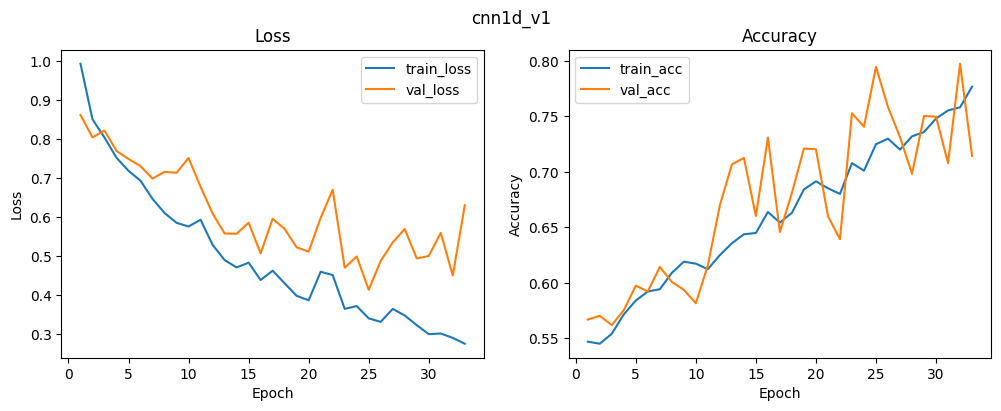

CNN metrics: {'accuracy': 0.7942130207034173, 'precision_macro': 0.35444649769317005, 'recall_macro': 0.41511666974853184, 'f1_macro': 0.34224959856651777, 'confusion_matrix': [[3133, 675, 36], [73, 50, 0], [29, 12, 1]], 'pr_auc_per_class': [0.9827667875786199, 0.09098425205171788, 0.055878389961552935], 'roc_auc_per_class': [0.7337613912275723, 0.7296580595759637, 0.8549671696256016], 'pr_auc_macro': 0.3765431431972969, 'roc_auc_macro': 0.7727955401430459}


In [ ]:
# @title 6.2: Run 1D-CNN
# Module 6.2: Run 1D-CNN
# reshape features to (samples, timesteps=1, features) for Conv1D
X_train_cnn = np.expand_dims(X_train_full, axis=1)   # (N, 1, n_feats)
X_hold_cnn = np.expand_dims(X_holdout, axis=1)
timesteps = X_train_cnn.shape[1]
n_feats = X_train_cnn.shape[2]
n_classes = len(np.unique(y_train_full))

cnn_result = run_single_model(
    model_builder_fn=lambda input_len, n_feats, n_classes: build_cnn_1d(input_len, n_feats, n_classes),
    model_name="cnn1d_v1",
    X_train=X_train_cnn,
    y_train=y_train_full,
    X_holdout=X_hold_cnn,
    y_holdout=y_holdout,
    thresholds=CONFIG["DEFAULT_THRESHOLDS"],
    use_class_weight=True,
    builder_kwargs={"input_len": timesteps, "n_feats": n_feats, "n_classes": n_classes}
)

print("CNN metrics:", cnn_result["metrics"])



# Module 7 — Final Comparison

**Purpose:**  

*   Aggregates metrics from all models into a single comparison table.  

*   Also displays confusion matrices and saves a summary CSV.




*This module provides the final view for selecting the best-performing model.*

,model,accuracy,precision_macro,recall_macro,f1_macro,pr_auc_macro,roc_auc_macro,outdir
0,mlp,0.837116,0.380286,0.534561,0.39113,0.376264,0.769764,outputs/mlp_v1_20251204_102202
1,cnn1d,0.794213,0.354446,0.415117,0.34225,0.376543,0.772796,outputs/cnn1d_v1_20251204_102654


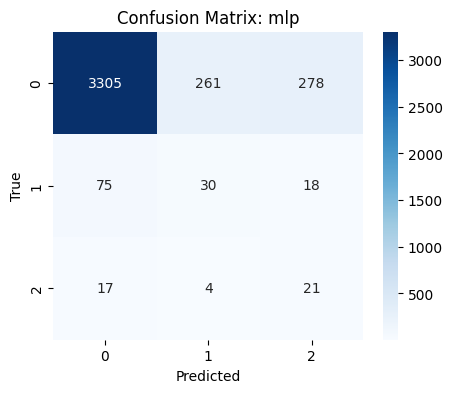

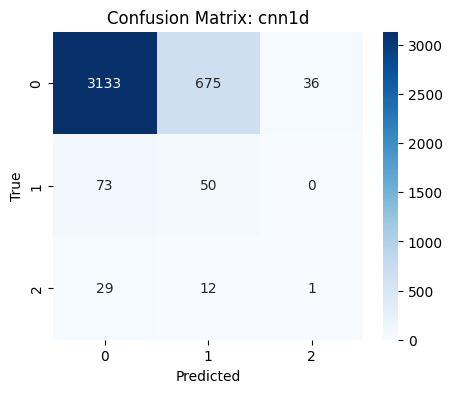

Saved comparison summary to outputs/model_comparison_summary.csv


In [ ]:
# @title Module 7: Final comparison
# Module 7: Final comparison and export
all_results = {}
if 'mlp_result' in globals():
    all_results['mlp'] = mlp_result
if 'cnn_result' in globals():
    all_results['cnn1d'] = cnn_result

rows = []
for name, res in all_results.items():
    m = res["metrics"]
    rows.append({
        "model": name,
        "accuracy": m.get("accuracy"),
        "precision_macro": m.get("precision_macro"),
        "recall_macro": m.get("recall_macro"),
        "f1_macro": m.get("f1_macro"),
        "pr_auc_macro": m.get("pr_auc_macro"),
        "roc_auc_macro": m.get("roc_auc_macro"),
        "outdir": res.get("outdir")
    })
metrics_df = pd.DataFrame(rows).sort_values(by="f1_macro", ascending=False)
display(metrics_df)

# plot confusion matrices for each model
for name, res in all_results.items():
    cm = np.array(res["metrics"]["confusion_matrix"])
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()

# save summary CSV
metrics_df.to_csv(os.path.join(CONFIG["OUTPUT_DIR"], "model_comparison_summary.csv"), index=False)
print("Saved comparison summary to", os.path.join(CONFIG["OUTPUT_DIR"], "model_comparison_summary.csv"))
